In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, ZeroPadding2D, Add,add,AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model
import imgaug as ia
import imgaug.augmenters as iaa


from os import listdir
from os.path import isfile, join
from PIL import Image
import glob


seed = 2019
np.random.seed(seed)
%matplotlib inline

In [2]:
tf.__version__

'2.1.0'

In [3]:

dirname = ''
train_path = os.path.join(dirname, 'OCT2017/train')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')
train_cnv_pth = os.path.join(train_path, 'CNV')
    
test_path = os.path.join(dirname, 'OCT2017/test')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')
test_cnv_pth = os.path.join(test_path, 'CNV')
    
val_path = os.path.join(dirname, 'OCT2017/val')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')
val_cnv_pth = os.path.join(val_path, 'CNV')



In [ ]:
def plot_imgs(item_dir, num_imgs=4):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(16, 16))
    for idx, img_path in enumerate(item_files):
        plt.subplot(1, 4, idx+1)

        img = cv2.imread(img_path)
        #img_eq = cv2.equalizeHist(img)

        plt.imshow(img)

    plt.tight_layout()

In [ ]:
plot_imgs(test_normal_pth)

In [ ]:
plot_imgs(test_normal_pth)

In [ ]:
def Images_details_Print_data(data, path):
    print(" ====== Images in: ", path)    
    for k, v in data.items():
        print("%s:\t%s" % (k, v))

def Images_details(path):
    files = [f for f in glob.glob(path + "**/*.*", recursive=True)]
    data = {}
    data['images_count'] = len(files)
    data['min_width'] = 10**100  # No image will be bigger than that
    data['max_width'] = 0
    data['min_height'] = 10**100  # No image will be bigger than that
    data['max_height'] = 0


    for f in files:
        im = Image.open(f)
        width, height = im.size
        data['min_width'] = min(width, data['min_width'])
        data['min_height'] = min(height, data['min_height'])
        data['max_width'] = max(width, data['max_height'])
        
        data['max_height'] = max(height, data['max_height'])

    Images_details_Print_data(data, path)

In [ ]:
Images_details(train_normal_pth)
Images_details(train_dme_pth)
Images_details(train_drusen_pth)
Images_details(train_cnv_pth)



In [ ]:
input_path = "OCT2017/"

for _set in ['train', 'test', 'val']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    dme = len(os.listdir(input_path + _set + '/DME'))
    drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
    cnv = len(os.listdir(input_path + _set + '/CNV'))
    print('{}, Normal images: {}, DME images: {}, DRUSEN images: {}, CNV images: {}'.format(_set, normal, dme, drusen, cnv))

In [4]:
import imgaug as ia
import imgaug.augmenters as iaa

seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),
        iaa.Invert(0.2),
        #iaa.Rotate((-45, 45)),
        #iaa.GaussianBlur(sigma=(0, 3.0)) 
        #iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization())
        # blur images with a sigma of 0 to 3.0
    ])
def augment(img):
        seq_det = seq.to_deterministic()
        
        aug_image = seq_det.augment_image(img)
        return aug_image
    
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        zoom_range = 0.3,
        horizontal_flip = True
        #preprocessing_function = augment 
    )
    
    test_datagen = ImageDataGenerator(
      #  featurewise_center=True,
      #  featurewise_std_normalization=True,
        rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory = train_path, 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'categorical', 
    shuffle=True)

    test_gen = test_datagen.flow_from_directory(
    directory=val_path, 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='categorical', 
    shuffle=True)
    
    return train_gen, test_gen

In [5]:
PARAMS = {'img_dims': 160,
          'epochs': 35,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'categorical_accuracy',
          }


In [6]:
#train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = False
session = tf.compat.v1.InteractiveSession(config=config)
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
# Constant to control how often we print when training models

# Constant to control how often we print when training models
print_every = 100

train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
inputs = Input(shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))


Found 67059 images belonging to 4 classes.
Found 544 images belonging to 4 classes.


In [7]:
def identity_block(X, f, filters):
    
    # Defining name basis
   
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    #1st conv block
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    #2nd conv block
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    #3rd conv block 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)

    #add and relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    X_shortcut = X

    #1st conv block
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s),padding="valid")(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #2nd conv block
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1),padding= "same")(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    #3rd conv block
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding ="valid")(X)
    X = BatchNormalization(axis=3)(X)

    #shortcut
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s),padding="valid")(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    #add and relu
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [9]:
filters= [(64, 64, 256),(128, 128, 512),(256, 256, 1024),(512, 512, 2048)]

X = ZeroPadding2D((3,3))(inputs)
# First conv block
X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1')(X)
X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPool2D((3, 3), strides=(2, 2))(X)


# Stage 2
X = convolutional_block(X, f = 3, filters = filters[0] )
X = identity_block(X, 3,filters[0])
X = identity_block(X, 3,filters[0])
# Stage 3
X = convolutional_block(X, f=3, filters=filters[1])
X = identity_block(X, 3, filters[1])
X = identity_block(X, 3, filters[1])
X = identity_block(X, 3, filters[1])

# Stage 4
X = convolutional_block(X, f=3, filters=filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])
X = identity_block(X, 3, filters[2])

# Stage 5
X = convolutional_block(X, f=3, filters=filters[3])
X = identity_block(X, 3, filters[3])
X = identity_block(X, 3,filters[3])

# Average pool, flatten and dense to 4 
X = AveragePooling2D(pool_size=(2,2), padding='same')(X)
X = Flatten()(X)
X = Dense(4, activation='softmax')(X)

# Creating model and compiling
model = Model(inputs=inputs, outputs=X)
model.compile(optimizer=PARAMS['optimizer'], loss=PARAMS['loss'], metrics=["categorical_accuracy"])

In [10]:
from sklearn.utils import class_weight
y_train = train_gen.classes

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 166, 166, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 80, 80, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 80, 80, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________

In [12]:


history = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // PARAMS['batch_size'], 
           epochs=PARAMS['epochs'],
         class_weight=class_weights,
           
           validation_data=test_gen)
           #callbacks=[checkpoint, lr_reduce])


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2095 steps, validate for 17 steps
Epoch 1/35
2095/2095 [==============================] - 507s 242ms/step - loss: 1.3350 - categorical_accuracy: 0.6145 - val_loss: 0.8746 - val_categorical_accuracy: 0.6875
Epoch 2/35
2095/2095 [==============================] - 495s 236ms/step - loss: 0.5287 - categorical_accuracy: 0.8293 - val_loss: 64.1090 - val_categorical_accuracy: 0.3750
Epoch 3/35
2095/2095 [==============================] - 492s 235ms/step - loss: 0.3966 - categorical_accuracy: 0.8712 - val_loss: 1.4611 - val_categorical_accuracy: 0.8732
Epoch 4/35
2095/2095 [==============================] - 494s 236ms/step - loss: 0.3478 - categorical_accuracy: 0.8869 - val_loss: 0.5464 - val_categorical_accuracy: 0.8824
Epoch 5/35
2095/2095 [==============================] - 492s 235ms/step - loss: 0.3517 - categorical_accuracy: 0.8886 - val_loss: 0.2623 - va

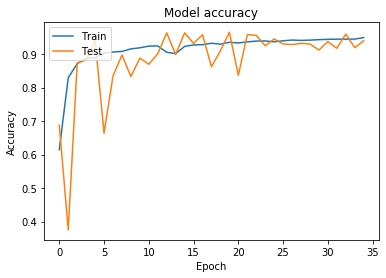

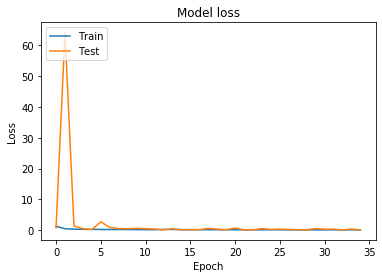

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
model.save("resnet_classweights")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: resnet_classweights\assets


In [ ]:

new_model = tf.keras.models.load_model('resnet_cw')

# Check its architecture
new_model.summary()

In [15]:
eval_test_datagen = ImageDataGenerator(
#  featurewise_center=True,
#  featurewise_std_normalization=True,
rescale=1./255)

# This is fed to the network in the specified batch sizes and image dimensions
eval_test_gen = eval_test_datagen.flow_from_directory(
directory = test_path, 
target_size = (160, 160), 
batch_size = 32,
class_mode = 'categorical', 
shuffle=False)
model.evaluate(eval_test_gen)

Found 16588 images belonging to 4 classes.
  ...
    to  
  ['...']
519/519 [==============================] - 105s 202ms/step - loss: 0.4148 - categorical_accuracy: 0.8730


[0.4147662861054246, 0.8729805]

In [ ]:
train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

In [16]:

test_data = []
test_labels = []

for cond in ['/CNV/', '/DME/', '/DRUSEN/' ,'/NORMAL/']:
    for img in (os.listdir(test_path + cond)):
        img = plt.imread(test_path + cond + img)
        img = cv2.resize(img, (160, 160))
        img = np.dstack([img, img, img])

        img = img.astype('float32') / 255
        if cond=='/NORMAL/':
            label = 3
        elif cond=='/DME/':
            label = 1
        elif cond=='/DRUSEN/':
            label = 2
        elif cond=='/CNV/':
            label = 0
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

#conf = confusion_matrix(test_labels, pred_ys)

In [17]:
Y = model.predict(test_data,batch_size = 32)
y_pred = np.argmax(Y,axis = 1)
print(test_labels)
print(y_pred)
num_errors = 0
print(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != test_labels[i]:
        num_errors += 1
        print("found another error, error count : ", num_errors)

[0 0 0 ... 3 3 3]
[0 0 2 ... 2 3 3]
16588
found another error, error count :  1
found another error, error count :  2
found another error, error count :  3
found another error, error count :  4
found another error, error count :  5
found another error, error count :  6
found another error, error count :  7
found another error, error count :  8
found another error, error count :  9
found another error, error count :  10
found another error, error count :  11
found another error, error count :  12
found another error, error count :  13
found another error, error count :  14
found another error, error count :  15
found another error, error count :  16
found another error, error count :  17
found another error, error count :  18
found another error, error count :  19
found another error, error count :  20
found another error, error count :  21
found another error, error count :  22
found another error, error count :  23
found another error, error count :  24
found another error, error coun

found another error, error count :  1986
found another error, error count :  1987
found another error, error count :  1988
found another error, error count :  1989
found another error, error count :  1990
found another error, error count :  1991
found another error, error count :  1992
found another error, error count :  1993
found another error, error count :  1994
found another error, error count :  1995
found another error, error count :  1996
found another error, error count :  1997
found another error, error count :  1998
found another error, error count :  1999
found another error, error count :  2000
found another error, error count :  2001
found another error, error count :  2002
found another error, error count :  2003
found another error, error count :  2004
found another error, error count :  2005
found another error, error count :  2006
found another error, error count :  2007
found another error, error count :  2008
found another error, error count :  2009
found another er

In [18]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(test_labels, y_pred)

print(conf)

[[5957  199  542    8]
 [   6 2329   16   51]
 [  32   19 1822   89]
 [  27  116 1176 4199]]
